<a href="https://colab.research.google.com/github/vinicius-mattoso/churn_project/blob/main/ChurnModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho final da Sprint 3 do Curso Ciência de Dados e Analytics da PUC-Rio


Aluno: Vinicius Mattoso Reis da Silva

Ulitma Atualização : 21/04/2024

## Explicação da temática do problema

Esse trabalho tem por objetivo a contrução de um modelo de classificação do churn do cliente. Churn de cliente é o fato de um cliente da sua base cancela o serviço por algum motivo, fazer um modelo capaz de prever se o cliente vai abandonar a empresa permite uma melhor organização gerencial além de conseguir produzir ações mais certeiras e efetivas para evitar que esse cliente saia da empresa.

## Etapas do projeto

1) Análise Exploratória da base de dados:

  Essa análise pode ser encontrada nesse outro notebook

https://github.com/vinicius-mattoso/churn_project/blob/main/ChurnEDA.ipynb

2) Criação de modelos Base para classificação:

  Presente notebook

3) Otimização dos hyperparâmetros do modelo que possui uma melhor acertividade

  Presente notebook

### Carregar as libs necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM

seed = 42

## Criação de uma classe para fazer todo o processamento inical dos dados


Essa classe será montada de acordo com as informações que foram obtidas no notebook de análise exploratória



In [2]:
class ChurnDataProcess ():
  def __init__(self,original_df):
    self.original_df = original_df
    self.modified_df = original_df.copy()

  def convert_total_charge_to_float(self):
    self.modified_df['TotalCharges'] = pd.to_numeric(self.modified_df['TotalCharges'], errors='coerce')

  def fill_nan_with_mean(self):
    self.modified_df['TotalCharges'].fillna((self.modified_df['TotalCharges'].mean()), inplace=True)

  def remove_id_column(self):
    self.modified_df.drop(columns='customerID', inplace=True)

  def use_only_select_columns(self):
    colunas_interessantes = ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
                                'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod',
                                'MonthlyCharges', 'TotalCharges', 'Churn']
    self.modified_df = self.modified_df[colunas_interessantes]

  def encoding_data(self):
    le = LabelEncoder()
    self.modified_df_encoding = self.modified_df.copy()
    for column in self.modified_df_encoding.columns:
        if self.modified_df_encoding[column].dtype == 'object':
            self.modified_df_encoding[column] = le.fit_transform(self.modified_df_encoding[column])

  def return_data_preprocessed(self):

    return self.modified_df_encoding


## Início da criação dos modelos

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/vinicius-mattoso/churn_project/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Utilização da classe de pre processamento**

In [4]:
data = ChurnDataProcess(df)

**Etapas para obter o dataframe final para ser utilizado pelo modelo**

In [5]:
# converter o tipo de dado
data.convert_total_charge_to_float()
# utilizar apenas as colunas selecionadas
data.use_only_select_columns()
data.fill_nan_with_mean()
# Criação de um dataset utilizando o one hot encoder
data.encoding_data()
# Retonar o dataset pronto para ser consumido
dataframe_prepared = data.return_data_preprocessed()
#Print data
dataframe_prepared.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,0,2,0,0,0,1,2,29.85,29.85,0
1,0,0,0,34,2,0,2,0,1,0,3,56.95,1889.50,0
2,0,0,0,2,2,2,0,0,0,1,3,53.85,108.15,1
3,0,0,0,45,2,0,2,2,1,0,0,42.30,1840.75,0
4,0,0,0,2,0,0,0,0,0,1,2,70.70,151.65,1


In [6]:
dataframe_prepared.isnull().sum()

SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Separar dados de treino e dados de teste

In [7]:
# Assuming 'Churn' is the target variable
X = dataframe_prepared.drop(columns=['Churn'])  # All columns except 'Churn' are features
y = dataframe_prepared['Churn']  # 'Churn' column as target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)  # Splits the data

# Convert to array all the informations
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values


In [8]:
# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=seed) # faz o particionamento em 10 folds

KNN: 0.760205 (0.013797)
CART: 0.726489 (0.020065)
NB: 0.744234 (0.020981)
SVM: 0.734465 (0.014147)


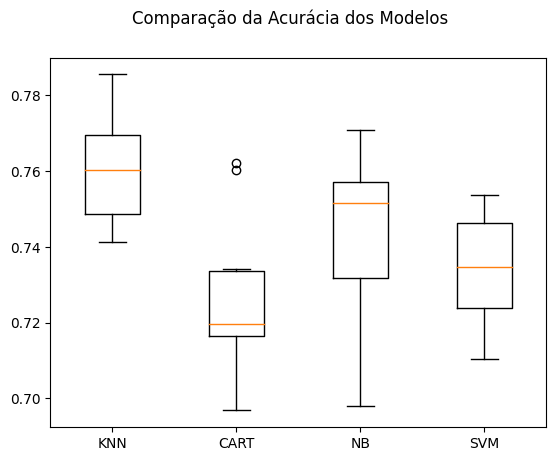

In [9]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(seed)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [10]:
# Criando um modelo com todo o conjunto de treino
model = GaussianNB()
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# Estimando a acurácia no conjunto de teste
print(accuracy_score(y_test, predictions))

0.7579843860894251
